In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [0]:
dvn = pd.read_csv('/content/drive/My Drive/Devnagari Text to image/data.csv')

In [0]:
dvn.head(5)

,pixel_0000,pixel_0001,pixel_0002,pixel_0003,pixel_0004,pixel_0005,pixel_0006,pixel_0007,pixel_0008,pixel_0009,pixel_0010,pixel_0011,pixel_0012,pixel_0013,pixel_0014,pixel_0015,pixel_0016,pixel_0017,pixel_0018,pixel_0019,pixel_0020,pixel_0021,pixel_0022,pixel_0023,pixel_0024,pixel_0025,pixel_0026,pixel_0027,pixel_0028,pixel_0029,pixel_0030,pixel_0031,pixel_0032,pixel_0033,pixel_0034,pixel_0035,pixel_0036,pixel_0037,pixel_0038,pixel_0039,...,pixel_0985,pixel_0986,pixel_0987,pixel_0988,pixel_0989,pixel_0990,pixel_0991,pixel_0992,pixel_0993,pixel_0994,pixel_0995,pixel_0996,pixel_0997,pixel_0998,pixel_0999,pixel_1000,pixel_1001,pixel_1002,pixel_1003,pixel_1004,pixel_1005,pixel_1006,pixel_1007,pixel_1008,pixel_1009,pixel_1010,pixel_1011,pixel_1012,pixel_1013,pixel_1014,pixel_1015,pixel_1016,pixel_1017,pixel_1018,pixel_1019,pixel_1020,pixel_1021,pixel_1022,pixel_1023,character
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,character_01_ka
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,character_01_ka
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,character_01_ka
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,character_01_ka
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,character_01_ka


In [0]:
dvn.describe()

,pixel_0000,pixel_0001,pixel_0002,pixel_0003,pixel_0004,pixel_0005,pixel_0006,pixel_0007,pixel_0008,pixel_0009,pixel_0010,pixel_0011,pixel_0012,pixel_0013,pixel_0014,pixel_0015,pixel_0016,pixel_0017,pixel_0018,pixel_0019,pixel_0020,pixel_0021,pixel_0022,pixel_0023,pixel_0024,pixel_0025,pixel_0026,pixel_0027,pixel_0028,pixel_0029,pixel_0030,pixel_0031,pixel_0032,pixel_0033,pixel_0034,pixel_0035,pixel_0036,pixel_0037,pixel_0038,pixel_0039,...,pixel_0984,pixel_0985,pixel_0986,pixel_0987,pixel_0988,pixel_0989,pixel_0990,pixel_0991,pixel_0992,pixel_0993,pixel_0994,pixel_0995,pixel_0996,pixel_0997,pixel_0998,pixel_0999,pixel_1000,pixel_1001,pixel_1002,pixel_1003,pixel_1004,pixel_1005,pixel_1006,pixel_1007,pixel_1008,pixel_1009,pixel_1010,pixel_1011,pixel_1012,pixel_1013,pixel_1014,pixel_1015,pixel_1016,pixel_1017,pixel_1018,pixel_1019,pixel_1020,pixel_1021,pixel_1022,pixel_1023
count,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,...,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0,92000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
dvn.shape

(92000, 1025)

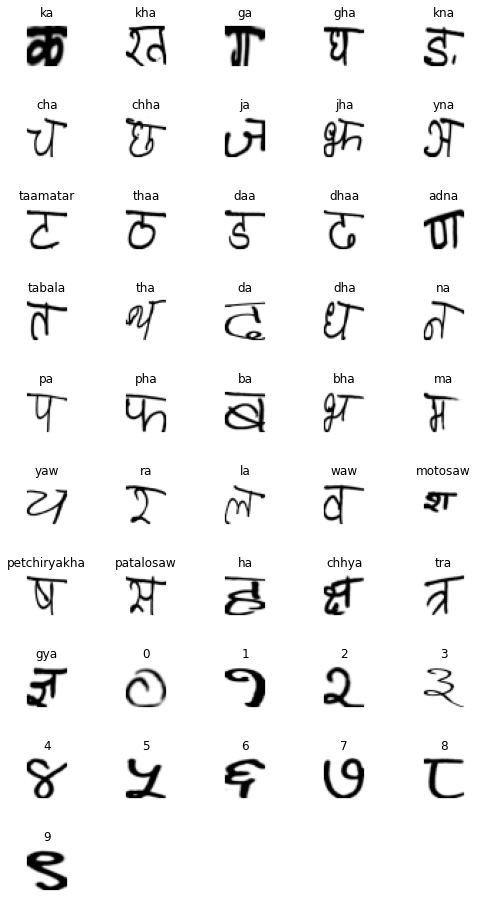

In [0]:
char_names = dvn.character.unique()  
rows =10;columns=5;
fig, ax = plt.subplots(rows,columns, figsize=(8,16))
for row in range(rows):
    for col in range(columns):
        ax[row,col].set_axis_off()
        if columns*row+col < len(char_names):
            x = dvn[dvn.character==char_names[columns*row+col]].iloc[0,:-1].values.reshape(32,32)
            x = x.astype("float64")
            x/=255
            ax[row,col].imshow(x, cmap="binary")
            ax[row,col].set_title(char_names[columns*row+col].split("_")[-1])

            
plt.subplots_adjust(wspace=1, hspace=1)      

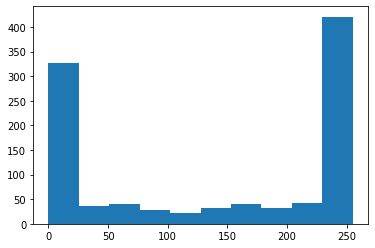

In [0]:
#pixel distribution of the dataset
plt.hist(dvn.iloc[0,:-1])
plt.show()

In [0]:
X=dvn.iloc[:,:-1]/255
y=dvn.iloc[:,-1].values

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [0]:
X_train.shape

(73600, 1024)

In [0]:
X_test.shape

(23000, 1024)

In [0]:
y_train.shape

(69000,)

In [0]:
y_test.shape

(23000,)

In [0]:
char_names=dvn.character.unique()

In [0]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

In [0]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_test = to_categorical(y_test,num_classes=46)
y_train = to_categorical(y_train,num_classes=46)

In [0]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
img_height_rows = 32
img_width_cols = 32

In [0]:
from keras import regularizers

In [0]:
im_shape = (img_height_rows, img_width_cols,1)
X_train = X_train.values.reshape(X_train.shape[0], *im_shape) #* unpacks the tuple
X_test = X_test.values.reshape(X_test.shape[0], *im_shape)

In [0]:
X_test.shape

(18400, 32, 32, 1)

In [0]:
model = Sequential()
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='Same'))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',activity_regularizer=regularizers.l2(1e-4)))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='Same'))
model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(units=128,activation='relu'))
model.add(Dense(units=64,activation='relu'))
model.add(Dense(units=46,activation='softmax'))

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)             

In [0]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(monitor='val_loss',patience=10)

In [0]:
history=model.fit(X_train,y_train,batch_size=32,epochs=100,verbose=1,callbacks=[es],validation_split=0.2,shuffle=True)

Train on 58880 samples, validate on 14720 samples
Epoch 1/100
58880/58880 [==============================] - 10s 175us/step - loss: 0.7656 - accuracy: 0.8268 - val_loss: 0.2735 - val_accuracy: 0.9425
Epoch 2/100
58880/58880 [==============================] - 10s 172us/step - loss: 0.2280 - accuracy: 0.9511 - val_loss: 0.1833 - val_accuracy: 0.9583
Epoch 3/100
58880/58880 [==============================] - 10s 172us/step - loss: 0.1529 - accuracy: 0.9657 - val_loss: 0.1440 - val_accuracy: 0.9660
Epoch 4/100
58880/58880 [==============================] - 10s 172us/step - loss: 0.1183 - accuracy: 0.9728 - val_loss: 0.1282 - val_accuracy: 0.9675
Epoch 5/100
58880/58880 [==============================] - 10s 172us/step - loss: 0.0961 - accuracy: 0.9779 - val_loss: 0.1179 - val_accuracy: 0.9718
Epoch 6/100
58880/58880 [==============================] - 10s 173us/step - loss: 0.0836 - accuracy: 0.9802 - val_loss: 0.1160 - val_accuracy: 0.9721
Epoch 7/100
58880/58880 [=========================

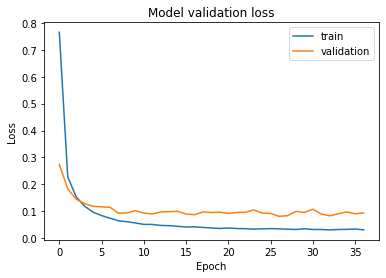

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','validation'], loc='upper right')
plt.show()

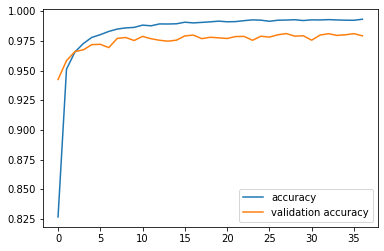

In [0]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.legend(loc='best')
plt.show()

In [0]:
model.save('final_model.h5')

**The final model is ready as we have nearly fitted the model by tuning parameters and hyperparameters.**


In [0]:
import cv2 
import tensorflow as tf
CHARACTERS = [dvn['character'].unique()]
for i in CHARACTERS:
  print(i)

['character_01_ka' 'character_02_kha' 'character_03_ga' 'character_04_gha'
 'character_05_kna' 'character_06_cha' 'character_07_chha'
 'character_08_ja' 'character_09_jha' 'character_10_yna'
 'character_11_taamatar' 'character_12_thaa' 'character_13_daa'
 'character_14_dhaa' 'character_15_adna' 'character_16_tabala'
 'character_17_tha' 'character_18_da' 'character_19_dha' 'character_20_na'
 'character_21_pa' 'character_22_pha' 'character_23_ba' 'character_24_bha'
 'character_25_ma' 'character_26_yaw' 'character_27_ra' 'character_28_la'
 'character_29_waw' 'character_30_motosaw' 'character_31_petchiryakha'
 'character_32_patalosaw' 'character_33_ha' 'character_34_chhya'
 'character_35_tra' 'character_36_gya' 'digit_0' 'digit_1' 'digit_2'
 'digit_3' 'digit_4' 'digit_5' 'digit_6' 'digit_7' 'digit_8' 'digit_9']


In [0]:
def prepare(kha):
  img_array = cv2.imread(kha.png,cv2.imread_grayscale)
  new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
  return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [0]:
from keras.models import load_model
model1 = load_model('final_model.h5')